In [1]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
min_speed, max_speed, nb_speed_brackets = 0.0, 200.0, 20
speed_bracket_size = (max_speed - min_speed) / nb_speed_brackets

def mph_to_kph(mph):
    return mph / 0.621371

def get_speed_label(speed_mph):
    speed_kph = mph_to_kph(speed_mph)
    if speed_kph >= max_speed:
        speed_kph = max_speed - 1
    elif speed_kph < min_speed:
        speed_kph = min_speed
    return (int) ((speed_kph - min_speed) / speed_bracket_size)

def get_speed_from_label(speed_label):
    if speed_label < 0 or speed_label > nb_speed_brackets:
        return 0
    return min_speed + speed_bracket_size * speed_label

def load_dataset(ds_filepath, test=False):
    train_labels = None
    with np.load(ds_filepath, mmap_mode=None) as dataset:
        train_images, train_labels = dataset['train_images'], dataset['train_labels']
    # Create speed brackets where each bracket corresponds with a label.
    print('Min Speed={}, Max Speed={}'.format(mph_to_kph(train_labels.min()), mph_to_kph(train_labels.max())))
    train_labels = np.vectorize(lambda x: mph_to_kph(x))(train_labels)
    train_images = train_images.reshape(-1, 96, 128, 3)

    train_images = train_images[:,:,:,0] * 0.2989 + train_images[:,:,:,1]  * 0.5870  + train_images[:,:,:,2] * 0.1140
    print('Train dataset: image_shape={}, labels_shape={}'.format(train_images.shape, train_labels.shape))
    return train_images, train_labels

In [3]:
# Load the dataset
train_images, train_labels = load_dataset('data/train_dataset_15000_20400.npz')

Min Speed=0.0, Max Speed=23.963409943495915
Train dataset: image_shape=(5400, 96, 128), labels_shape=(5400,)


In [4]:
# Transform dataset
DEPTH = 8

# (BATCH, C, DEPTH, HEIGHT, WIDTH)
# empty_arrays = [np.zeros_like(train_images.shape) for _ in range(DEPTH - 1)]
# train_images = np.stack((train_images, empty_arrays), axis = 1)
# train_images = np.expand_dims(train_images, axis=1)

new_train_images = np.zeros((train_images.shape[0], 1, DEPTH, train_images.shape[1], train_images.shape[2]))

for i in range(0, train_images.shape[0]):
    if i < DEPTH:
        new_train_images[i, 0, 0 : i + 1] = train_images[0 : i + 1].reshape(i + 1, 96, 128)
#         train_labels[i] = np.mean(train_labels[0 : i + 1], axis = 0)
    else:
        new_train_images[i, 0] = train_images[i - DEPTH : i].reshape(DEPTH, 96, 128)
#         train_labels[i] = np.mean(train_labels[i - DEPTH : i], axis = 0)

new_train_images.shape

(5400, 1, 8, 96, 128)

In [5]:
train_images = new_train_images

train_labels_mod = np.vectorize(lambda x: get_speed_label(x))(train_labels)
train_labels_mod.min(), train_labels_mod.max()

(0, 3)

In [10]:
def one_hot_encode(x, n_classes):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
     """
    #return torch.tensor(np.eye(n_classes)[x])
    return torch.eye(n_classes)[(int)(x[0])]

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
BATCH_SIZE, D_out = 4, nb_speed_brackets

class SpeedNet(nn.Module):
    def __init__(self):
        super(SpeedNet, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, 3)
        self.conv2 = nn.Conv3d(32, 64, 3)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(365056, 128)
        self.fc2 = nn.Linear(128, D_out)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool3d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x_out = self.fc2(x)
        return F.log_softmax(x_out, dim = 1)

    def predict(self, x):
        return self(x)

In [11]:
device = torch.device("cpu")
ftype = torch.FloatTensor
ltype = torch.LongTensor
torch.backends.cuda.matmul.allow_tf32 = False
torch.autograd.set_detect_anomaly(True)
model = SpeedNet()
model.to(device)
print(model)
loss_function = nn.NLLLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

SpeedNet(
  (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=365056, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=20, bias=True)
)


Loss 2.4274, Accuracy 25.0000: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


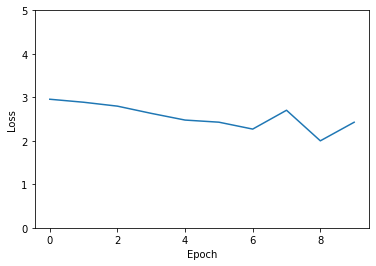

In [12]:
model.train()
losses = []
accuracies = []
t = trange(10)
for i in t:
    sample = np.random.randint(0, train_images.shape[0], BATCH_SIZE)
    X = torch.tensor(train_images[sample], device=device).type(ftype)
    Y = torch.tensor(train_labels_mod[sample], device=device).type(ltype)
    
    y_pred = model(X)

    # Compute and print loss
    loss = loss_function(y_pred, Y)
    accuracy = (y_pred.argmax(axis = 1) == Y).float().mean()
    t.set_description("Loss %.4f, Accuracy %.4f" % (loss.item(), 100.0 * accuracy))
    losses.append(loss.item())
    accuracies.append(accuracy)

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.ylim(0.0, 5.0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses, label='Loss')
# plt.plot(accuracies, label='Accuracy')

In [129]:
pretrained_model_path = 'data/pretrained_model_v2.tar'

In [130]:
model.train()
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses,
            },
    pretrained_model_path)

In [131]:
checkpoint = torch.load(pretrained_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
losses = checkpoint['losses']

model.eval()

SpeedNet(
  (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=365056, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=20, bias=True)
)

Actual speed: 15.247589604278282, Predicted speed: tensor([0.])
Batch indices: [1930 1751 1581 4722]
Mean Squared Error Loss: 18.499889373779297


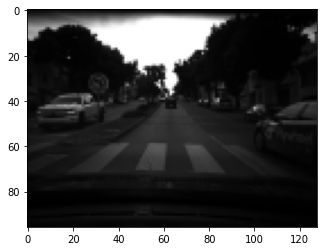

In [132]:
model.eval()
test_image_index = 3256 #[1723 1517 3247 3256]
test_images = train_images[test_image_index]
actual_speed = train_labels[test_image_index]
pylab.imshow(test_images[0,0], cmap='gray')

test_tensor = torch.tensor(test_images, device=device).type(ftype).unsqueeze(1)
predicted_speed =  model.predict(test_tensor)
predicted_speed = get_speed_from_label(predicted_speed.argmax(axis=1))
print('Actual speed: {}, Predicted speed: {}'.format(actual_speed, predicted_speed))

with torch.no_grad():
    sample = np.random.randint(0, train_images.shape[0], size=BATCH_SIZE)
    print('Batch indices: {}'.format(sample))
    X = torch.tensor(train_images[sample], device=device).type(ftype)
    Y = torch.tensor(train_labels[sample], device=device).type(ftype).view(BATCH_SIZE, 1)

    Y_pred = model(X).argmax(axis=1).reshape(BATCH_SIZE, 1)
    Y_pred = np.vectorize(lambda x: get_speed_from_label(x))(Y_pred.detach().cpu().numpy())
    Y_pred = torch.tensor(Y_pred, device=device).type(ftype)
    mse_loss = nn.MSELoss(reduction='mean')
    print('Mean Squared Error Loss: {}'.format(mse_loss(Y_pred, Y).item()))